# Tutorial 8 - Transformation of 2D free energy surfaces

## Introduction

This notebook illustrates the usage of ThermoLIB to transform a 2D free energy surface in terms of collective variables (CV1,CV2) towards a new FES in terms of new collective variables (Q1,Q2) in which the relation between (CV1,CV2) and (Q1,Q2) is given as a deterministic transformation formula. For the purpose of this illustration, we will chose a transformation that encodes a simply rotation in the (CV1,CV2) plane. Furthermore, to validate the implementation, we will also project the original FES on the CV1 axis and compare with the projection of the rotated FES on the rotated CV1 axis.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from thermolib.thermodynamics.fep import FreeEnergySurface2D, SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram2D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.error import Propagator
from thermolib.units import *

import numpy as np, matplotlib.pyplot as pp, time

Define some file/path variables

In [7]:
fn_meta = '/home/lvduyfhu/hpc/data_vo/shared/massimo/for_Louis/H-ZSM-5_ethylation/wham_input_2D.txt' #location of the plumed metadata file containing all information of the umbrella sampling

## Construction of original 2D FES

In [8]:
colvar_reader = ColVarReader([1,2], units=['au','au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/colvar_%s.dat', 
    bias_potential='Parabola2D', q01_unit='au', q02_unit='au', kappa1_unit='kjmol', kappa2_unit='kjmol',
)

/home/lvduyfhu/miniconda3/envs/test/lib/python3.14/site-packages/thermolib/tools.py:960: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


<Figure size 640x480 with 0 Axes>

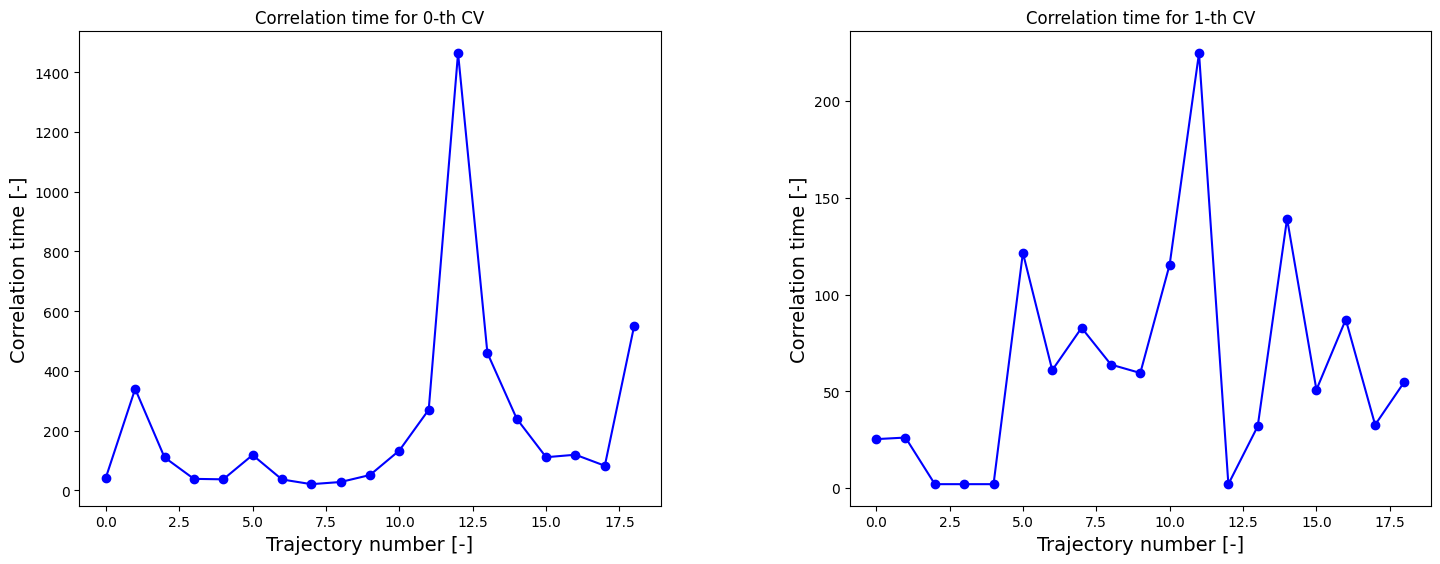

In [9]:
corrtimes = decorrelate(trajectories, plot=True)

Next, we construct the 2D probability histogram on the given 2D CV grid (defined by ``bins``) using the WHAM routine.

In [10]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist = Histogram2D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, error_p_threshold=1e-4)
hist_noerror = Histogram2D.from_wham(bins, trajectories, biasses, temp)

  SCF did not converge!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.022s
  bias poten. : 00h 00m 00.730s
  solve scf   : 00h 00m 00.345s
  error est.  : 00h 00m 13.492s
  TOTAL       : 00h 00m 14.592s
---------------------------------------------------------------------
  SCF did not converge!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.017s
  bias poten. : 00h 00m 00.765s
  solve scf   : 00h 00m 00.317s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 01.100s
---------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

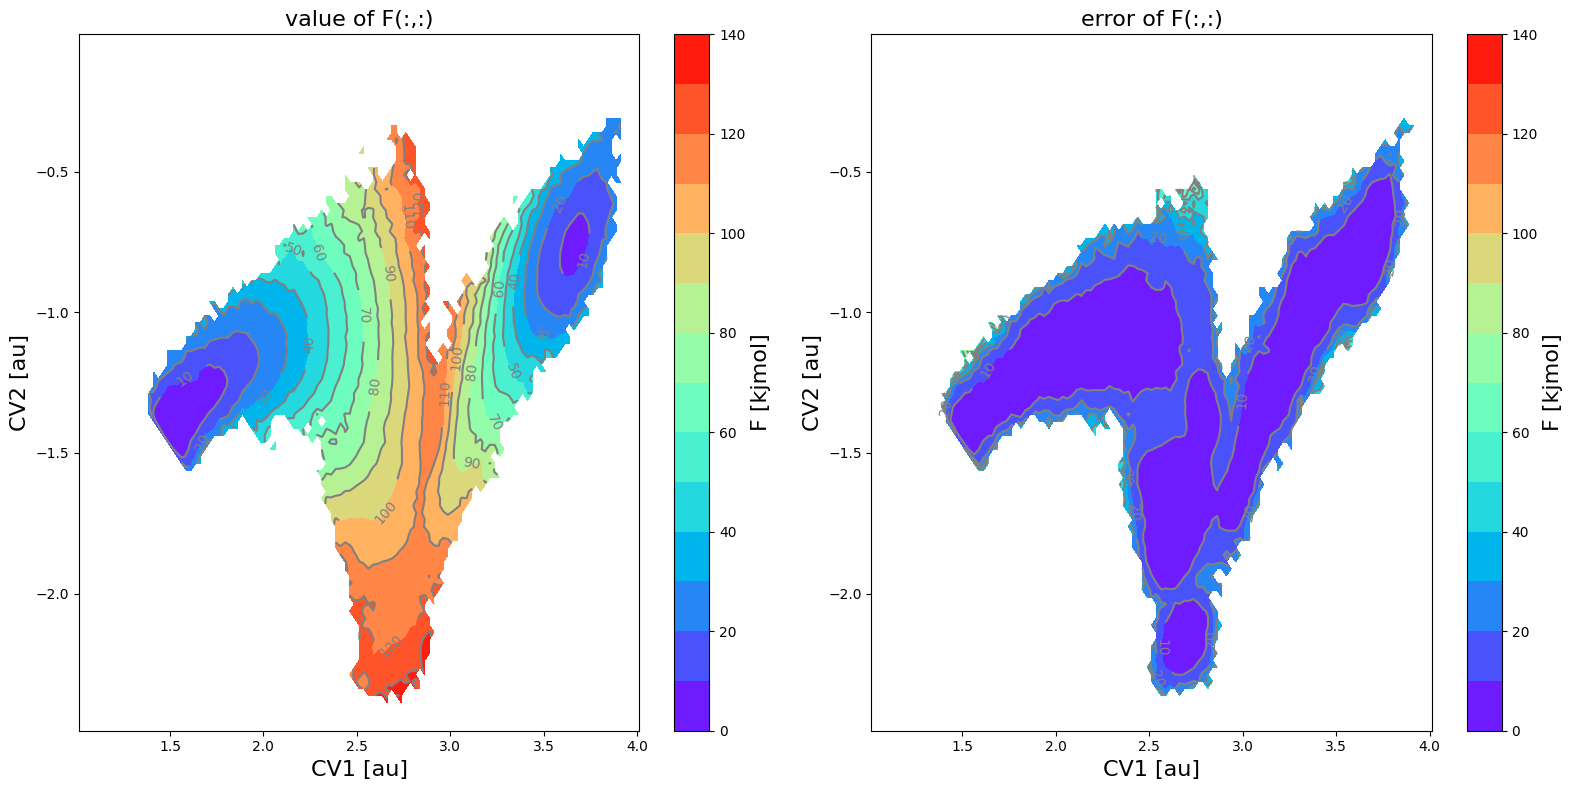

In [11]:
fes = FreeEnergySurface2D.from_histogram(hist, temp)
fes_noerror = FreeEnergySurface2D.from_histogram(hist_noerror, temp)
fes.set_ref(ref='min')
fes_noerror.set_ref(ref='min')
fes.plot(obss=['value', 'error'], cmap='rainbow', flims=[0,140], ncolors=14)

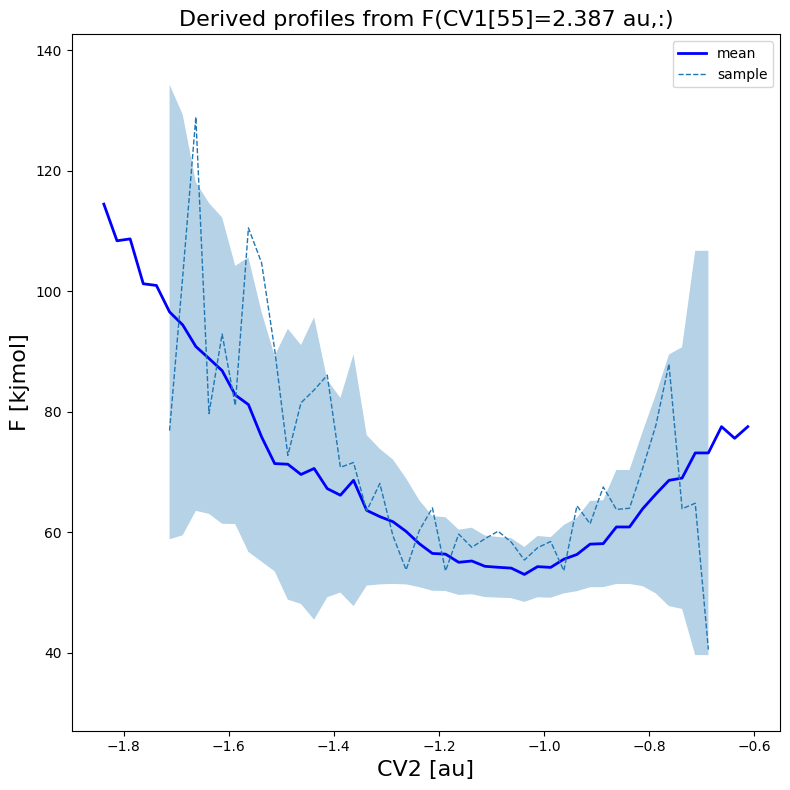

In [12]:
fes.plot(slicer=[55,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

## Transformation to new CVs

We transform $F_\text{CV}(CV_1,CV_2)$ to $F_\text{Q}(Q_1,Q_2)$ with:

\begin{align}
    Q_1 &= \frac{\sqrt{2}}{2}\left(CV_1 - 2.75 + CV_2 + 1.25\right) \\
    Q_2 &= \frac{\sqrt{2}}{2}\left(CV_2 + 1.25 - CV_1 + 2.75\right)
\end{align}

which simply encodes a rotation over 45 degrees around the point $(CV_1,CV_2)=(2.27,-1.25)$

In [13]:
f1 = lambda x,y: np.sqrt(2)/2*(x-2.75+y+1.25)
f2 = lambda x,y: np.sqrt(2)/2*(y+1.25-x+2.75)
derivatives = lambda x,y: ((np.sqrt(2)/2, np.sqrt(2)/2), (-np.sqrt(2)/2, np.sqrt(2)/2))
q1s = np.arange(-1.2,1.4+0.025,0.025)
q2s = np.arange(-1.0,1.0+0.025,0.025)
fes2 = fes.transform_function((f1,f2), q1s, q2s, derivatives=derivatives, cv1_label='Q1', cv2_label='Q2')

<Figure size 640x480 with 0 Axes>

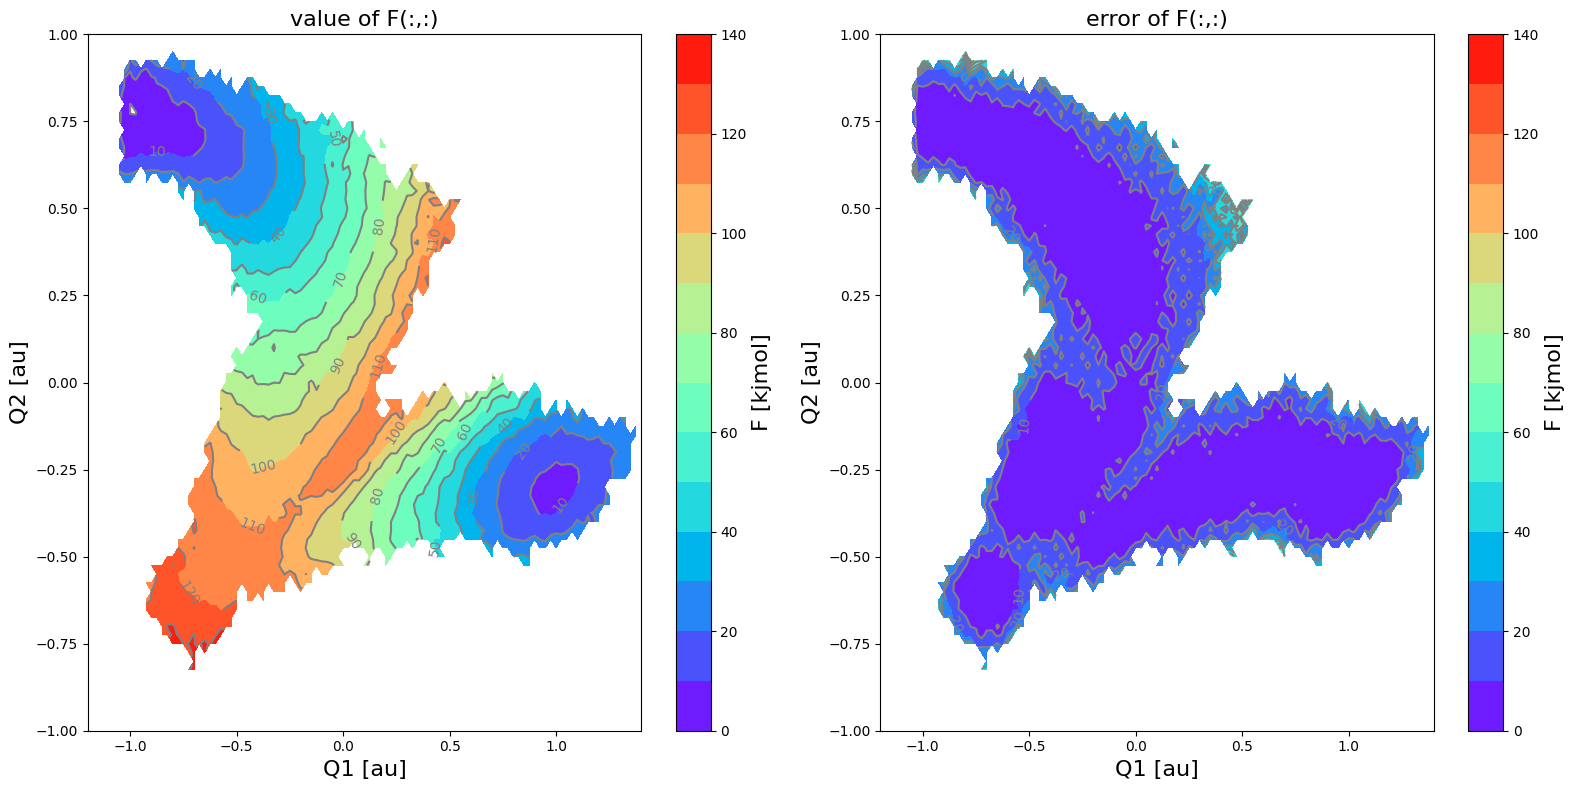

In [14]:
fes2.plot(obss=['value', 'error'], cmap='rainbow', flims=[0,140], ncolors=14)

Both the free energy itself as well as its error bar indeed seem to represent a rotated version of the original.

## Projection comparison

As a further comparison, we project the original FES on CV1 as well as the new FES on $f(Q_1,Q_2)=\frac{\sqrt{2}}{2}\left(Q_1-Q_2\right)+2.75=CV_1$ and compare on a 1D plot (with error bar).

In [15]:
fep = fes.project_cv1()

In [16]:
fun = lambda x,y: np.sqrt(2)/2*(x-y)+2.75
cv1s = np.arange(1,4.025,0.025)
fep2 = fes2.project_function(fun, cv1s)

<Figure size 640x480 with 0 Axes>

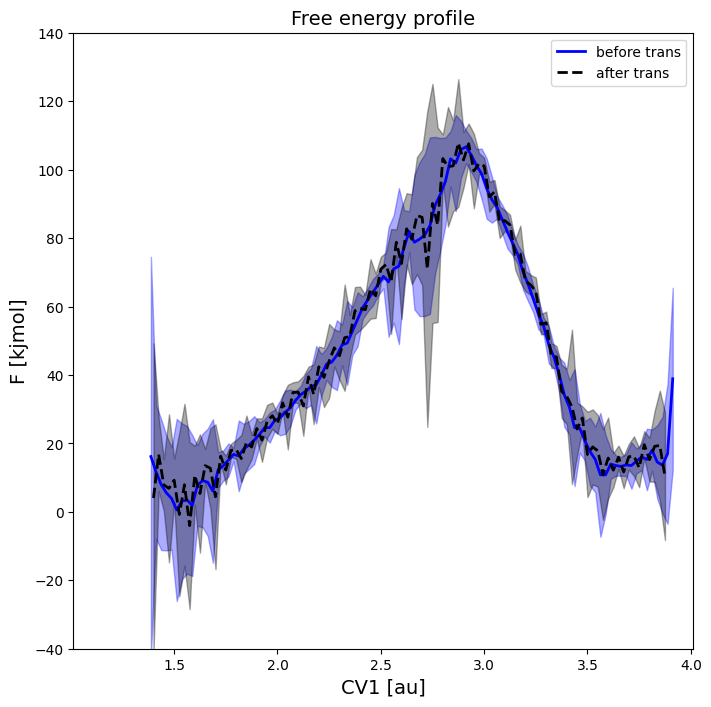

In [17]:
plot_profiles([fep,fep2], labels=['before trans','after trans'], linestyles=['-','--'], colors=['b','k'], flims=[-40,140])

This plot clearly illustrates that both projections are the same, further validating the implementation.